# Packages

In [1]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import time
import holidays

# Modelling
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer


from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.utils import AirPassengers as ap

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [2]:
df = pl.read_csv("../0_data/preprocessed/df_final.csv", try_parse_dates=True).filter(
    pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00")
)


df.head()

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-09-01 00:00:00,5.1633e6,14.276999,86.62722,12.077,14.274088,0.0,0.0,0.0,0.0,23.1,4.452954,8.0899935,14.036275,57.724377,10.440001,15.377,17.077002,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.494499,10.801474,0.0,0.0,0.0,0.0,1.5,7.9036193,20.140705,59.93151,…,3.319036,6.297428,130.60121,59.03632,13.32,11.744499,13.8945,14.294499,14.1445,0.416,0.423,0.403,0.413,0.0,13.192,88.84562,11.392,12.423903,0.0,0.0,0.0,0.0,4.2000003,8.217153,20.111729,28.810698,45.72514,20.519999,14.542001,16.042,16.142,15.642,0.382,0.375,0.359,0.394,0.0
2021-09-01 01:00:00,5.0777e6,13.177,91.223816,11.776999,13.115568,0.0,0.0,0.0,0.0,10.800001,4.198285,5.6233797,329.03632,39.805527,7.5599995,14.776999,16.977001,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.0945,10.245484,0.0,0.0,0.0,0.0,0.9,7.491114,19.770523,54.782326,…,6.3690495,9.422101,47.290634,43.451904,16.56,11.294499,13.744499,14.294499,14.1445,0.414,0.422,0.404,0.413,0.0,12.642,92.40392,11.442,11.601958,0.0,0.0,0.0,0.0,0.6,10.1887,23.233252,32.005356,40.601215,24.119999,14.192,15.892,16.142,15.642,0.381,0.375,0.359,0.394,0.0
2021-09-01 02:00:00,4.9315e6,13.377,88.56768,11.526999,13.566463,0.0,0.0,0.0,0.0,6.6000004,1.9386592,6.830519,21.801476,71.564964,6.8399997,14.627,16.977001,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,9.994499,10.04735,0.0,0.0,0.0,0.0,3.9,9.339208,21.578989,62.447273,…,4.0249224,6.297428,10.304792,30.963696,16.56,11.1945,13.744499,14.294499,14.1445,0.409,0.419,0.403,0.413,0.0,12.592,92.707214,11.442,11.363569,0.0,0.0,0.0,0.0,1.8000001,11.480557,23.469128,41.185825,48.731503,24.84,14.742001,16.042,16.142,15.642,0.378,0.374,0.358,0.394,0.0
2021-09-01 03:00:00,4.7878e6,13.077,89.72258,11.427,13.146872,0.0,0.0,0.0,0.0,0.6,2.5455842,2.7416782,278.13,23.198618,5.04,14.026999,16.827002,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.994499,9.884285,0.0,0.0,0.0,0.0

In [3]:
df.shape

(26304, 163)

In [4]:
df

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-09-01 00:00:00,5.1633e6,14.276999,86.62722,12.077,14.274088,0.0,0.0,0.0,0.0,23.1,4.452954,8.0899935,14.036275,57.724377,10.440001,15.377,17.077002,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.494499,10.801474,0.0,0.0,0.0,0.0,1.5,7.9036193,20.140705,59.93151,…,3.319036,6.297428,130.60121,59.03632,13.32,11.744499,13.8945,14.294499,14.1445,0.416,0.423,0.403,0.413,0.0,13.192,88.84562,11.392,12.423903,0.0,0.0,0.0,0.0,4.2000003,8.217153,20.111729,28.810698,45.72514,20.519999,14.542001,16.042,16.142,15.642,0.382,0.375,0.359,0.394,0.0
2021-09-01 01:00:00,5.0777e6,13.177,91.223816,11.776999,13.115568,0.0,0.0,0.0,0.0,10.800001,4.198285,5.6233797,329.03632,39.805527,7.5599995,14.776999,16.977001,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.0945,10.245484,0.0,0.0,0.0,0.0,0.9,7.491114,19.770523,54.782326,…,6.3690495,9.422101,47.290634,43.451904,16.56,11.294499,13.744499,14.294499,14.1445,0.414,0.422,0.404,0.413,0.0,12.642,92.40392,11.442,11.601958,0.0,0.0,0.0,0.0,0.6,10.1887,23.233252,32.005356,40.601215,24.119999,14.192,15.892,16.142,15.642,0.381,0.375,0.359,0.394,0.0
2021-09-01 02:00:00,4.9315e6,13.377,88.56768,11.526999,13.566463,0.0,0.0,0.0,0.0,6.6000004,1.9386592,6.830519,21.801476,71.564964,6.8399997,14.627,16.977001,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,9.994499,10.04735,0.0,0.0,0.0,0.0,3.9,9.339208,21.578989,62.447273,…,4.0249224,6.297428,10.304792,30.963696,16.56,11.1945,13.744499,14.294499,14.1445,0.409,0.419,0.403,0.413,0.0,12.592,92.707214,11.442,11.363569,0.0,0.0,0.0,0.0,1.8000001,11.480557,23.469128,41.185825,48.731503,24.84,14.742001,16.042,16.142,15.642,0.378,0.374,0.358,0.394,0.0
2021-09-01 03:00:00,4.7878e6,13.077,89.72258,11.427,13.146872,0.0,0.0,0.0,0.0,0.6,2.5455842,2.7416782,278.13,23.198618,5.04,14.026999,16.827002,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.994499,9.884285,0.0,0.0,0.0,0.0

# Missing values

Just forward fill for now.

In [5]:
df = df.fill_null(strategy="forward")

# Calendar Features

In [6]:
df = df.with_columns(
    day_of_month=pl.col("datetime").dt.day(),
    day_of_year=pl.col("datetime").dt.ordinal_day(),
    day_of_week=pl.col("datetime").dt.weekday(),
    is_weekend=pl.col("datetime").dt.weekday().is_in([6, 7]).cast(pl.Int32),
    week_of_month=(pl.col("datetime").dt.day() - 1) // 7 + 1,
    week_of_year=pl.col("datetime").dt.week(),
    month=pl.col("datetime").dt.month(),
    quarter=pl.col("datetime").dt.quarter(),
    hour=pl.col("datetime").dt.hour(),
    is_morning=pl.col("datetime").dt.hour().is_between(6, 11).cast(pl.Int32),
    is_afternoon=pl.col("datetime").dt.hour().is_between(12, 17).cast(pl.Int32),
    is_evening=pl.col("datetime").dt.hour().is_between(18, 23).cast(pl.Int32),
    is_night=(pl.col("datetime").dt.hour().is_between(0, 5)).cast(pl.Int32),
)

## Holidays

In [7]:
# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=df["datetime"].dt.year().unique().to_list(), prov=prov
)

In [8]:
holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

holiday_df.head()

holiday_name,holiday_date
str,date
"""Neujahrestag""",2021-01-01
"""Berchtoldstag""",2021-01-02
"""Karfreitag""",2021-04-02
"""Ostermontag""",2021-04-05
"""Tag der Arbeit""",2021-05-01


In [9]:
df = (
    df.with_columns(date=pl.col("datetime").dt.date())
    .join(holiday_df, how="left", left_on="date", right_on="holiday_date")
    .drop("date")
)

df.head()

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation,day_of_month,day_of_year,day_of_week,is_weekend,week_of_month,week_of_year,month,quarter,hour,is_morning,is_afternoon,is_evening,is_night,holiday_name
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i16,i8,i32,i8,i8,i8,i8,i8,i32,i32,i32,i32,str
2021-09-01 00:00:00,5.1633e6,14.276999,86.62722,12.077,14.274088,0.0,0.0,0.0,0.0,23.1,4.452954,8.0899935,14.036275,57.724377,10.440001,15.377,17.077002,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.494499,10.801474,0.0,0.0,0.0,0.0,1.5,7.9036193,20.140705,59.93151,…,13.192,88.84562,11.392,12.423903,0.0,0.0,0.0,0.0,4.2000003,8.217153,20.111729,28.810698,45.72514,20.519999,14.542001,16.042,16.142,15.642,0.382,0.375,0.359,0.394,0.0,1,244,3,0,1,35,9,3,0,0,0,0,1,null
2021-09-01 01:00:00,5.0777e6,13.177,91.223816,11.776999,13.115568,0.0,0.0,0.0,0.0,10.800001,4.198285,5.6233797,329.03632,39.805527,7.5599995,14.776999,16.977001,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.0945,10.245484,0.0,0.0,0.0,0.0,0.9,7.491114,19.770523,54.782326,…,12.642,92.40392,11.442,11.601958,0.0,0.0,0.0,0.0,0.6,10.1887,23.233252,32.005356,40.601215,24.119999,14.192,15.892,16.142,15.642,0.381,0.375,0.359,0.394,0.0,1,244,3,0,1,35,9,3,1,0,0,0,1,null
2021-09-01 02:00:00,4.9315e6,13.377,88.56768,11.526999,13.566463,0.0,0.0,0.0,0.0,6.6000004,1.9386592,6.830519,21.801476,71.564964,6.8399997,14.627,16.977001,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,9.994499,10.04735,0.0,0.0,0.0,0.0,3.9,9.339208,21.578989,62.447273,…,12.592,92.707214,11.442,11.363569,0.0,0.0,0.0,0.0,1.8000001,11.480557,23.469128,41.185825,48.731503,24.84,14.742001,16.042,16.142,15.642,0.378,0.374,0.358,0.394,0.0,1,244,3,0,1,35,9,3,2,0,0,0,1,null
2021-09-01 03:00:00,4.7878e6,13.077,89.72258,11.427,13.146872,0.0,0.0,0.0,0.0,0.6,2.5455842,2.7416782,278.13,23.198618,5.04,14.026999,16.827002,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.994499,9.884285,0.0,0.0,0.0,0.0,8.099999,9.085988,20.140705,56.3099,…,12.242001,92.68792,11.092,11.280403,0.0,0.0,0.0,0.0,2.1,8.913181,21.175837,43.36347,54.688713,26.64,14.242001,15.942,16.142,15.642,0.377,0.374,0.358,0.394,0.0,1,244,3,0,1,35,9,3,3,0,0,0,1,null
2021-09-01 04:00:00,4.7038e6,10.677,96.7212,10.177,9.91409,0.0,0.0,0.0,0.0,0.0,5.6920996,3.8773184,288.43503,338.19852,7.5599995,13.477,16.677,16.877,15.177,0.378,0.363,0.399,0.446,0.0,10.794499,94.804436,9.9

# Cyclical Encoding

In [10]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclically(column_name, periodicity, table):
    # Create sin and cos encoding
    table = table.with_columns(
        sin_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_sin")
    )

    table = table.with_columns(
        cos_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_cos")
    )
    # Drop the old column
    table = table.drop(column_name)

    return table

In [11]:
# Dictionary with column name and calendar periodicity
calendar_features = {
    "day_of_month": 31,
    "day_of_year": 365,
    "day_of_week": 7,
    "week_of_month": 4,
    "week_of_year": 52,
    "month": 12,
    "quarter": 4,
    "hour": 24,
}

for column_name, periodicity in calendar_features.items():
    df = encode_cyclically(column_name, periodicity, df)

# sklearn Pipeline

In [12]:
cat_cols = ["holiday_name"]

num_cols = df.select(
    cs.contains(
        "temperature_2m",
        "relative_humidity_2m",
        "dew_point_2m",
        "apparent_temperature",
        "precipitation",
        "rain",
        "snowfall",
        "snow_depth",
        "cloud_cover",
        "wind_speed_10m",
        "wind_speed_100m",
        "wind_direction_10m",
        "wind_direction_100m",
        "wind_gusts_10m",
        "soil_temperature_0_to_7cm",
        "soil_temperature_7_to_28cm",
        "soil_temperature_28_to_100cm",
        "soil_temperature_100_to_255cm",
        "soil_moisture_0_to_7cm",
        "soil_moisture_7_to_28cm",
        "soil_moisture_28_to_100cm",
        "soil_moisture_100_to_255cm",
        "shortwave_radiation",
    )
).columns

manual_cols = df.select(pl.selectors.contains("_cos", "_sin", "is_")).columns

In [13]:
df.drop(manual_cols + cat_cols + num_cols)

datetime,kWh
datetime[μs],f64
2021-09-01 00:00:00,5.1633e6
2021-09-01 01:00:00,5.0777e6
2021-09-01 02:00:00,4.9315e6
2021-09-01 03:00:00,4.7878e6
2021-09-01 04:00:00,4.7038e6
…,…
2024-08-31 19:00:00,5.3614e6
2024-08-31 20:00:00,5.3775e6
2024-08-31 21:00:00,5.2130e6


In [14]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean"))])


categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

# Making column transformer where all transformers in the pipelines are included
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

# Autocorrelation Visualisation

## No differencing

In [15]:
time_series = df.to_pandas()["kWh"]
acf_lags = 7 * 52

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.972902,0.960817,0.984987,1
2,0.907338,0.886783,0.927893,2
3,0.823625,0.797877,0.849373,3
4,0.736739,0.707394,0.766083,4


matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 

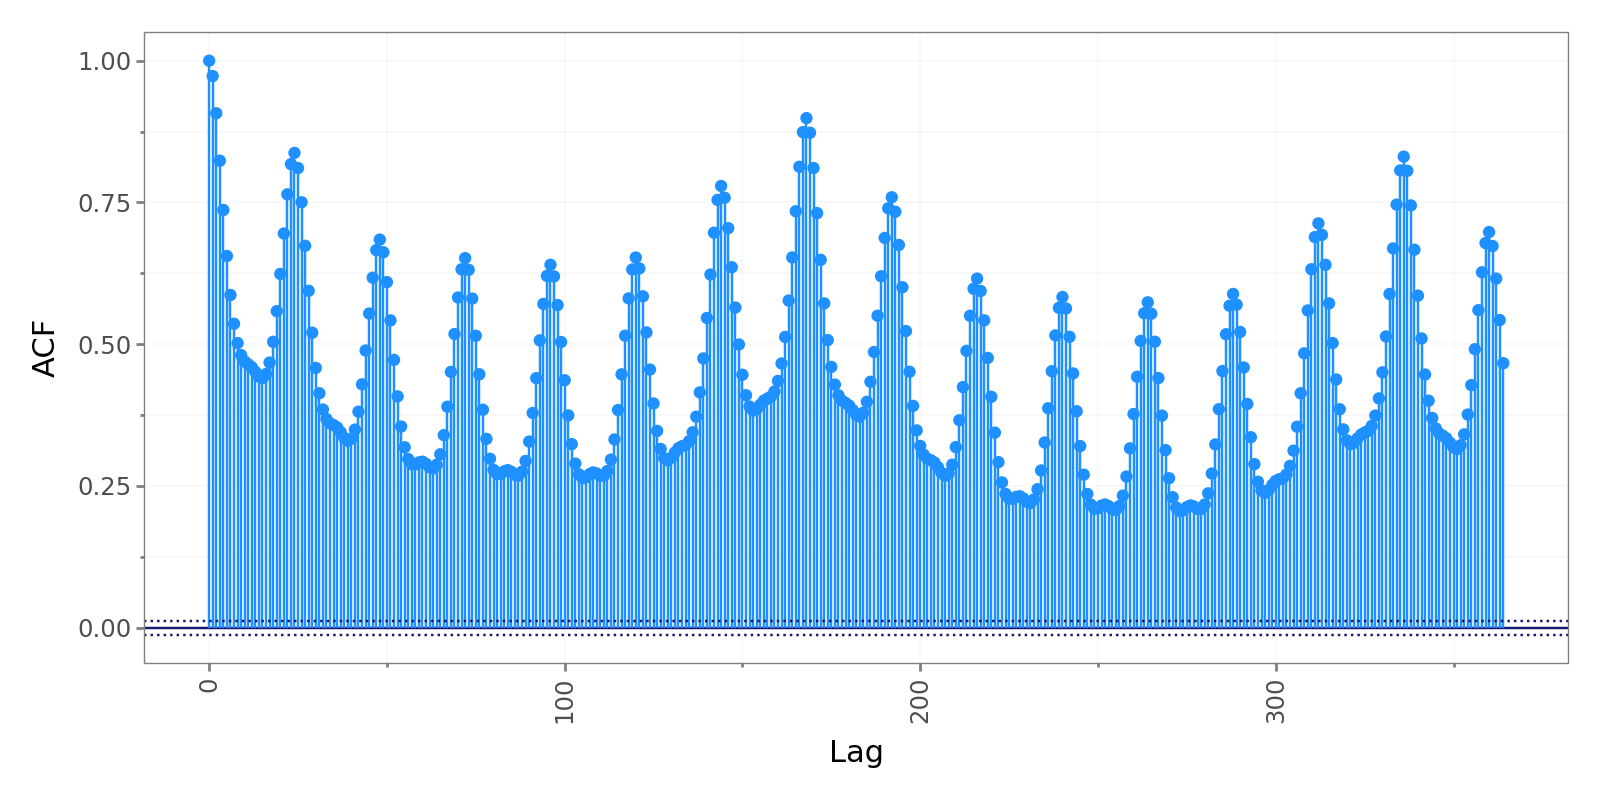

In [16]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [17]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.972939,0.960854,0.985024,1
2,-0.734299,-0.746384,-0.722215,2
3,0.285290,0.273205,0.297374,3
4,-0.003155,-0.015240,0.008930,4


matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 

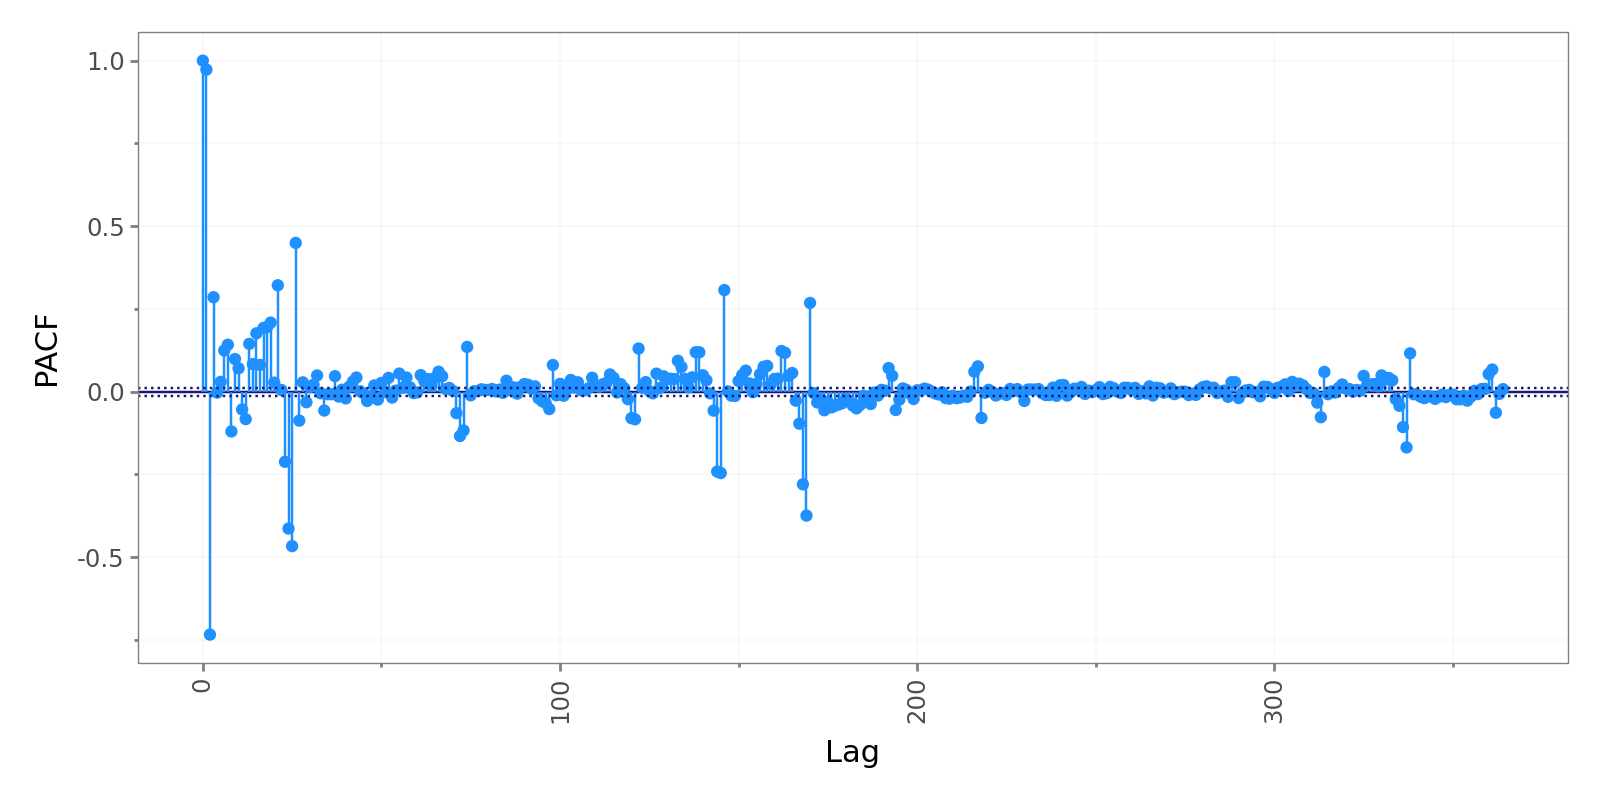

In [18]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [19]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [20]:
kpss_test(time_series)

Results of KPSS Test:
Test Statistic            3.932698
p-value                   0.010000
Lags Used                86.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\STEIM\AppData\Local\Temp\ipykernel_30612\11026176.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



## First order differencing

In [21]:
time_series = df.to_pandas()["kWh"]
time_series = (time_series - time_series.shift(1)).dropna()

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.711018,0.698934,0.723103,1
2,0.335399,0.318261,0.352537,2
3,0.058688,0.040617,0.076759,3
4,-0.106215,-0.124315,-0.088116,4


matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 

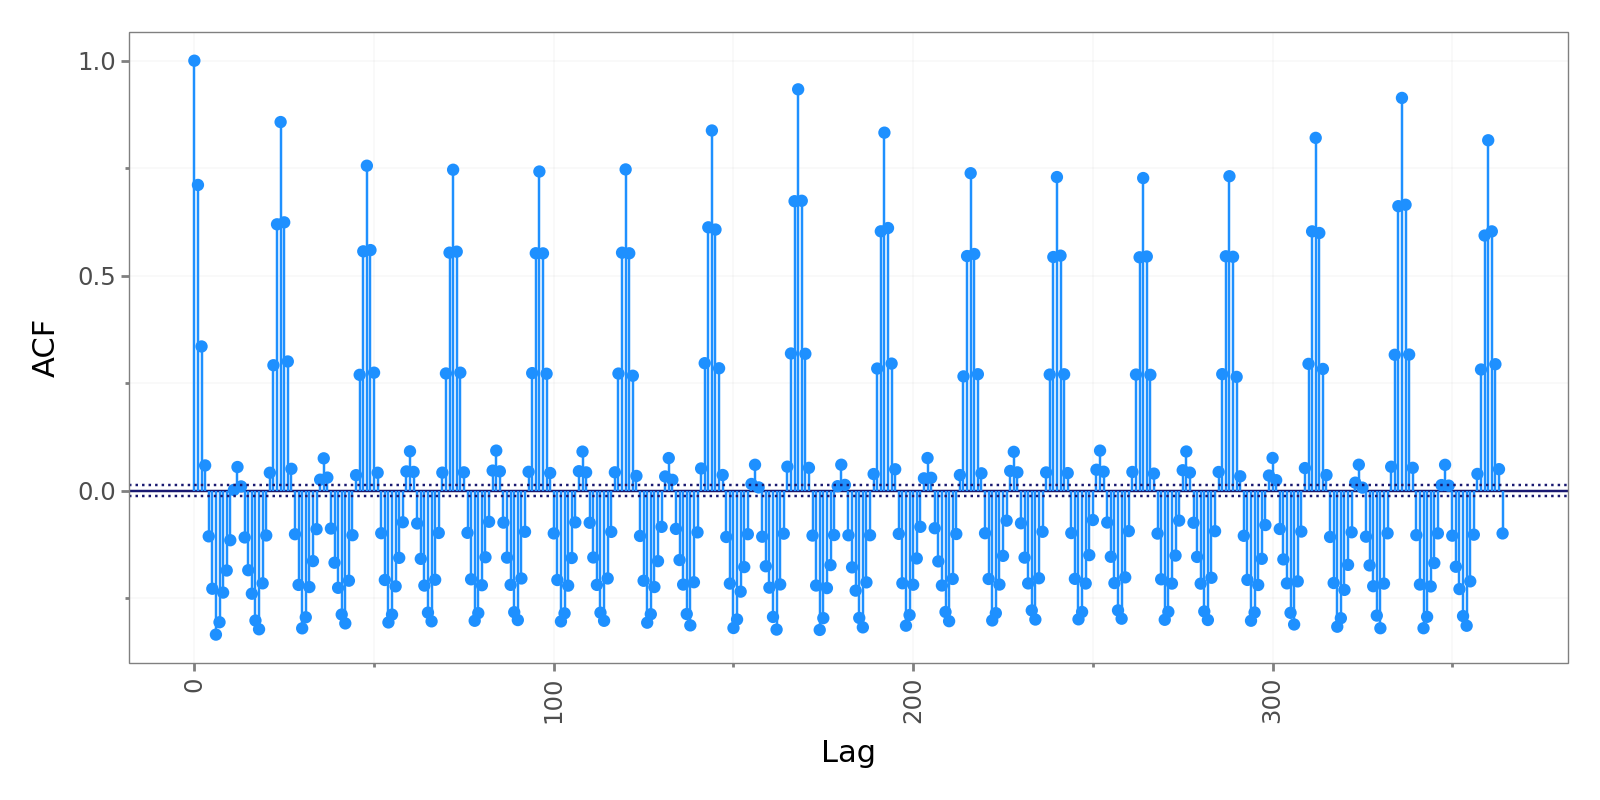

In [22]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [23]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.711046,0.698961,0.723130,1
2,-0.344167,-0.356252,-0.332082,2
3,-0.039404,-0.051489,-0.027319,3
4,-0.070561,-0.082645,-0.058476,4


matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 

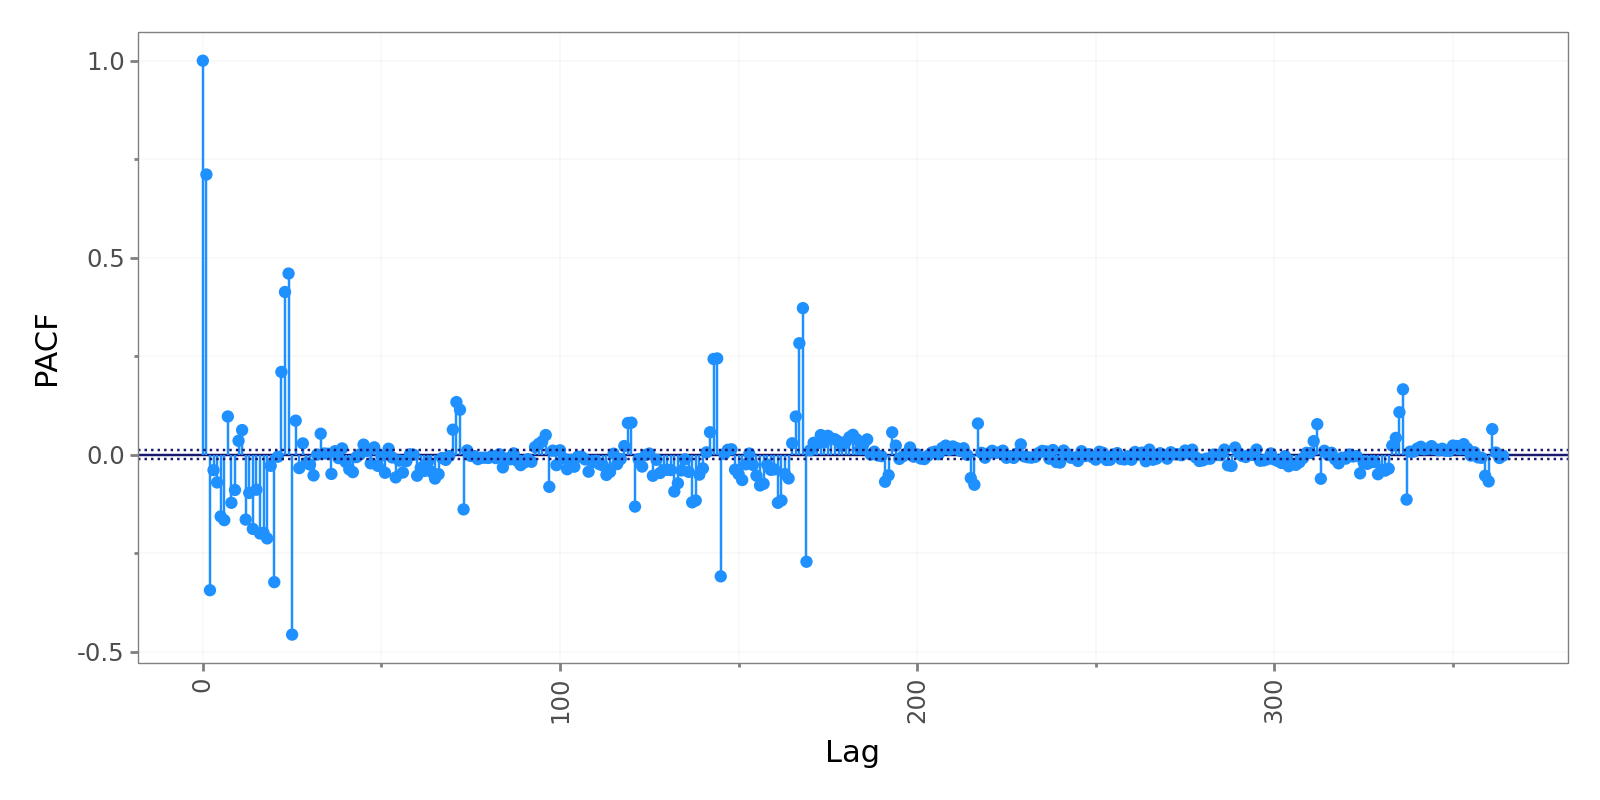

In [24]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [25]:
kpss_test(time_series)

Results of KPSS Test:
Test Statistic             0.023294
p-value                    0.100000
Lags Used                379.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\STEIM\AppData\Local\Temp\ipykernel_30612\11026176.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



## Second order differencing

In [26]:
time_series = df.to_pandas()["kWh"]
time_series = (time_series - time_series.shift(1)).dropna()
time_series = (time_series - time_series.shift(1)).dropna()

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.149948,0.137862,0.162033,1
2,-0.171152,-0.183506,-0.158798,2
3,-0.193418,-0.206114,-0.180723,3
4,-0.074484,-0.087603,-0.061365,4


matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 

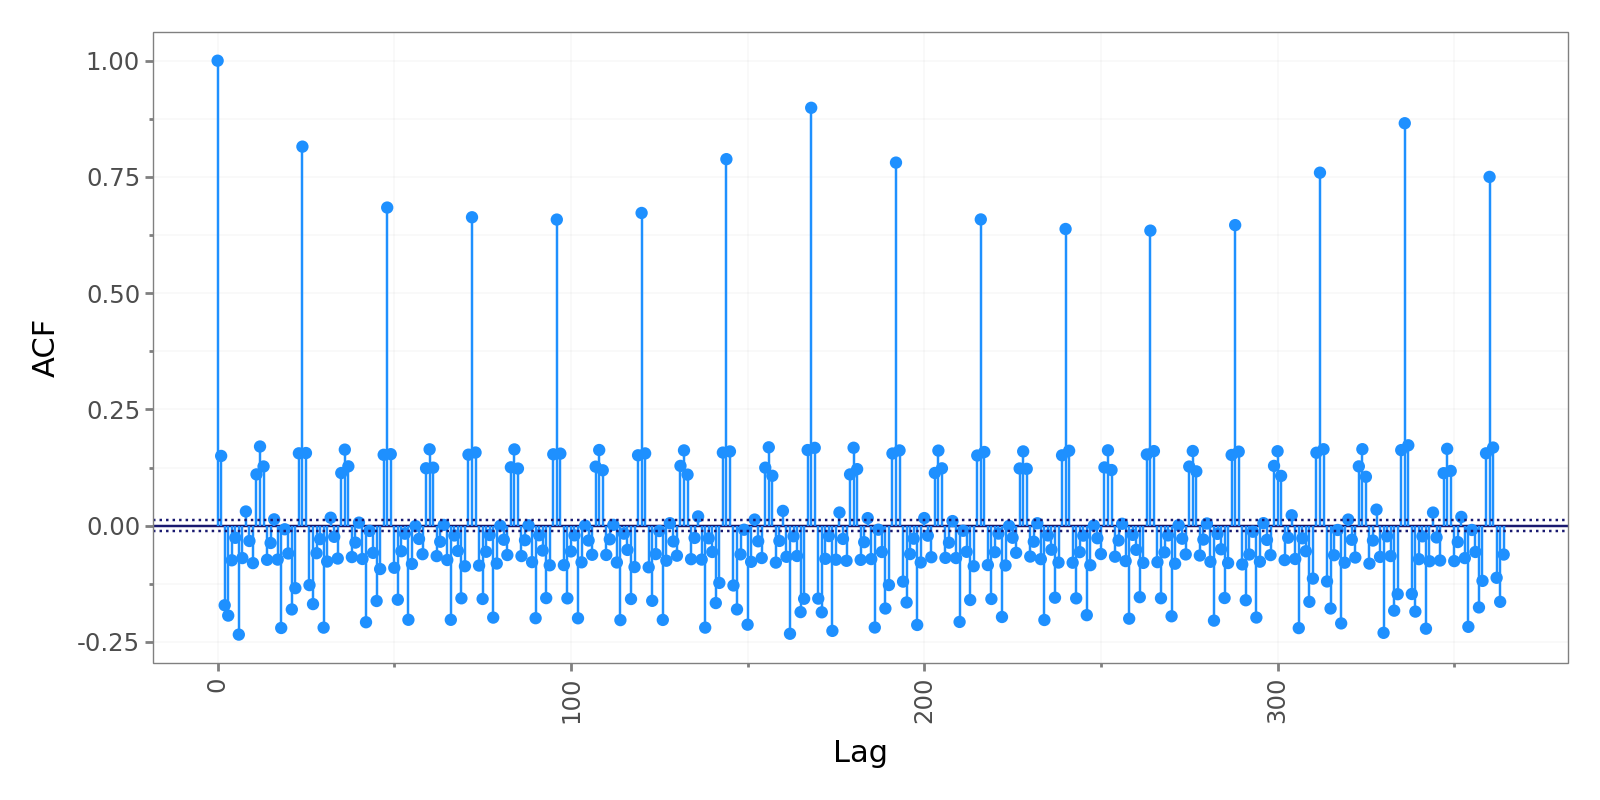

In [27]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [28]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.149953,0.137868,0.162038,1
2,-0.198105,-0.210190,-0.186020,2
3,-0.141599,-0.153684,-0.129513,3
4,-0.058120,-0.070206,-0.046035,4


matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 

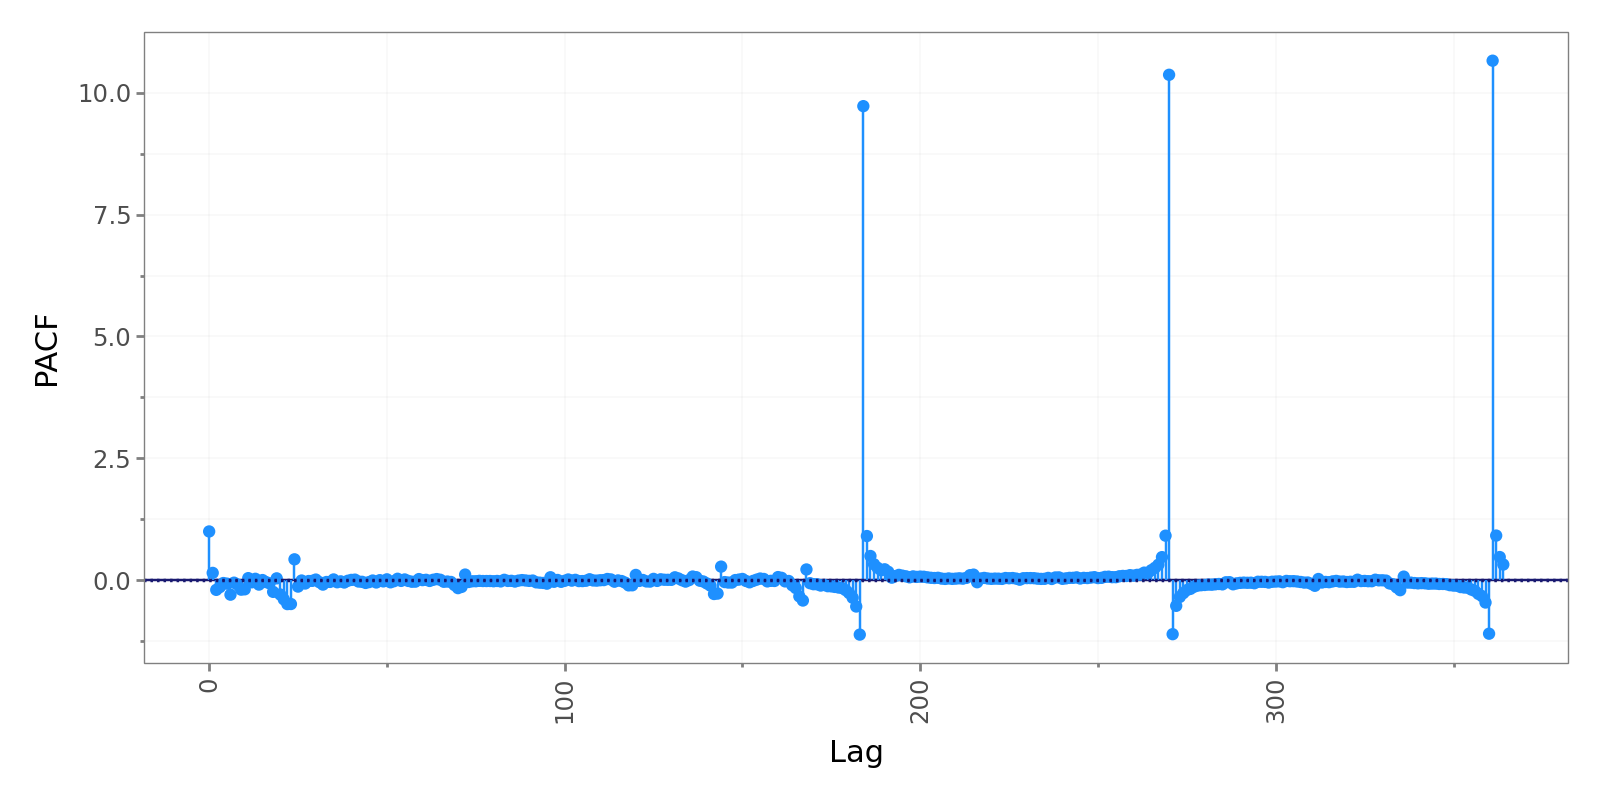

In [29]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

# Order Selection (Parameter Tuning) with `statsforecast`

## Computational complexity extrapolation chart

In [30]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,Bern_wind_direction_100m,Bern_wind_gusts_10m,Bern_soil_temperature_0_to_7cm,Bern_soil_temperature_7_to_28cm,Bern_soil_temperature_28_to_100cm,Bern_soil_temperature_100_to_255cm,Bern_soil_moisture_0_to_7cm,Bern_soil_moisture_7_to_28cm,Bern_soil_moisture_28_to_100cm,Bern_soil_moisture_100_to_255cm,Bern_shortwave_radiation,Geneva_temperature_2m,Geneva_relative_humidity_2m,Geneva_dew_point_2m,Geneva_apparent_temperature,Geneva_precipitation,Geneva_rain,Geneva_snowfall,Geneva_snow_depth,Geneva_cloud_cover,Geneva_wind_speed_10m,Geneva_wind_speed_100m,Geneva_wind_direction_10m,Geneva_wind_direction_100m,Geneva_wind_gusts_10m,Geneva_soil_temperature_0_to_7cm,Geneva_soil_temperature_7_to_28cm,Geneva_soil_temperature_28_to_100cm,Geneva_soil_temperature_100_to_255cm,Geneva_soil_moisture_0_to_7cm,Geneva_soil_moisture_7_to_28cm,Geneva_soil_moisture_28_to_100cm,Geneva_soil_moisture_100_to_255cm,Geneva_shortwave_radiation,Lugano_temperature_2m,Lugano_relative_humidity_2m,Lugano_dew_point_2m,Lugano_apparent_temperature,Lugano_precipitation,Lugano_rain,Lugano_snowfall,Lugano_snow_depth,Lugano_cloud_cover,Lugano_wind_speed_10m,Lugano_wind_speed_100m,Lugano_wind_direction_10m,Lugano_wind_direction_100m,Lugano_wind_gusts_10m,Lugano_soil_temperature_0_to_7cm,Lugano_soil_temperature_7_to_28cm,Lugano_soil_temperature_28_to_100cm,Lugano_soil_temperature_100_to_255cm,Lugano_soil_moisture_0_to_7cm,Lugano_soil_moisture_7_to_28cm,Lugano_soil_moisture_28_to_100cm,Lugano_soil_moisture_100_to_255cm,Lugano_shortwave_radiation,Sion_temperature_2m,Sion_relative_humidity_2m,Sion_dew_point_2m,Sion_apparent_temperature,Sion_precipitation,Sion_rain,Sion_snowfall,Sion_snow_depth,Sion_cloud_cover,Sion_wind_speed_10m,Sion_wind_speed_100m,Sion_wind_direction_10m,Sion_wind_direction_100m,Sion_wind_gusts_10m,Sion_soil_temperature_0_to_7cm,Sion_soil_temperature_7_to_28cm,Sion_soil_temperature_28_to_100cm,Sion_soil_temperature_100_to_255cm,Sion_soil_moisture_0_to_7cm,Sion_soil_moisture_7_to_28cm,Sion_soil_moisture_28_to_100cm,Sion_soil_moisture_100_to_255cm,Sion_shortwave_radiation,St_temperature_2m,St_relative_humidity_2m,St_dew_point_2m,St_apparent_temperature,St_precipitation,St_rain,St_snowfall,St_snow_depth,St_cloud_cover,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation,is_weeken

In [31]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [32]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [33]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [34]:
X_train_preprocessed = X_train_preprocessed.apply(pd.to_numeric, errors="coerce")
X_val_preprocessed = X_val_preprocessed.apply(pd.to_numeric, errors="coerce")

In [35]:
n_obs_list = np.arange(50, 500 + 1, 50)
fit_times = []

for n_obs in tqdm(n_obs_list):

    model = ARIMA(
        order=(1, 1, 1),
        season_length=24,
        seasonal_order=(1, 1, 1),
        # include_drift=True
    )

    start_time = time.time()
    model.fit(
        y=y_train.to_numpy(dtype=np.float64),
        X=X_train_preprocessed.to_numpy(dtype=np.float64),
    )
    end_time = time.time()
    fit_times.append((end_time - start_time) / 60)

  0%|          | 0/10 [00:00<?, ?it/s]

matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 'Latin Modern Roman' not found.
matplotlib.font_manager WARNING findfont: Font family 

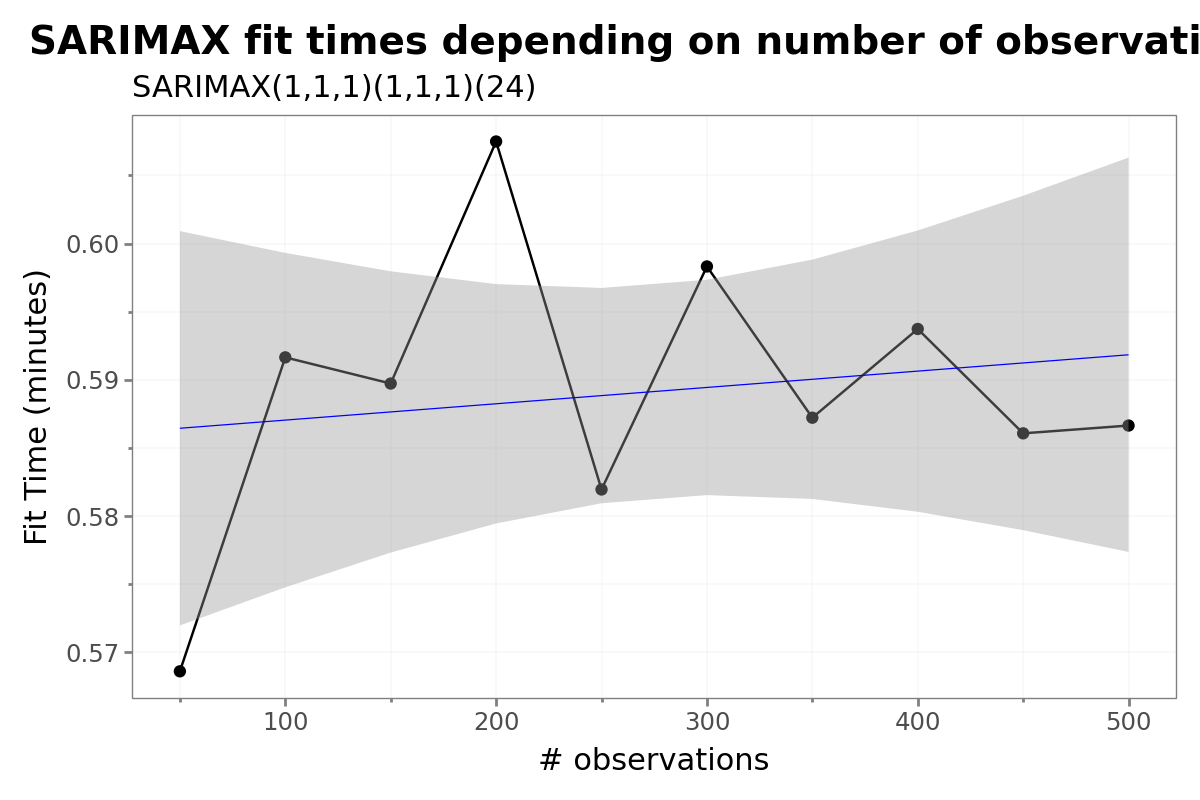

In [36]:
(
    pn.ggplot(
        data=pd.DataFrame({"n": n_obs_list, "fit_time": fit_times}),
        mapping=pn.aes("n", "fit_time"),
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(
        title="SARIMAX fit times depending on number of observations",
        subtitle="SARIMAX(1,1,1)(1,1,1)(24)",
        x="# observations",
        y="Fit Time (minutes)",
    )
    + pn.geom_smooth(method="lm", colour="blue", size=0.25)
    + theme_academic
)

Extrapolation linearly: SARIMAX on quarter hourly data with this configuration will take (minutes):

In [37]:
4 * df.shape[0] / n_obs_list[-1] * fit_times[-1]

123.44853178100585

## Manually Fitting a Model

In [38]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [39]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [40]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [41]:
# from statsforecast import StatsForecast

# X_train_preprocessed = X_train_preprocessed.assign(ds=df_train.index, unique_id="kWh")
# X_val_preprocessed = X_val_preprocessed.assign(ds=df_val.index, unique_id="kWh")

# StatsForecast(
#     models=[model],
# )

In [42]:
model = ARIMA(
    order=(1, 1, 1),
    season_length=24,
    seasonal_order=(1, 1, 1),
    # include_drift=True
)

In [43]:
model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [44]:
y_preds = model.forward(
    y=y_train.to_numpy(dtype=np.float64),
    h=24,
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
    X_future=X_val_preprocessed.head(24).to_numpy(dtype=np.float64),
)["mean"]

y_preds

array([5118609.19557856, 4971132.98311934, 4938501.22645834,
       4717317.29933394, 4588288.37260352, 4843762.37943368,
       5483255.40517786, 6118840.1533701 , 6528790.90119494,
       6645844.14730783, 6748387.94464161, 6952204.42478703,
       6684665.32514115, 6618243.64640352, 6615761.63131505,
       6413163.82073028, 6296464.98240422, 6325565.73257416,
       6306250.64871205, 6208198.33823629, 5956870.24767113,
       5851749.95792979, 5748038.60849139, 5430375.59181489])

In [45]:
preds = pd.DataFrame(
    {
        "y_pred": y_preds,
        "y_true": y_val.head(24),
    }
)

In [46]:
def validation(model, X_train, X_val, y_train, y_val, verbose=True):
    # Validation loop (predict the next 24 hours for the validation period)
    X_train_val = pd.concat([X_train, X_val], axis=0)
    y_train_val = pd.concat([y_train, y_val], axis=0)

    val_index = X_train.shape[0]
    horizon = 24
    val_preds = np.array([])

    while val_index + horizon <= X_train_val.shape[0]:

        y_pred = model.forward(
            y=y_train_val[:val_index].to_numpy(dtype=np.float64),
            h=24,
            X=X_train_val[:val_index].to_numpy(dtype=np.float64),
            X_future=X_train_val[val_index : val_index + horizon].to_numpy(
                dtype=np.float64
            ),
        )["mean"]

        # Append to array
        val_preds = np.append(val_preds, y_pred)

        # Increment validation index
        val_index += horizon

        if (val_position := val_index - X_train.shape[0]) % 24 == 0:
            print(f"Hour {val_position} of {X_val.shape[0]}")
            clear_output(wait=True)

    return np.vstack(val_preds).flatten()

In [ ]:
y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)



y_preds_val = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

Hour 744 of 744


In [48]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

## RayTune Tuning Setup

Repeat the same as manual fit (train/val split), but do order selection via OptunaSearch

In [49]:
def sarimax_trainable(config, df_train, df_val):

    try:
        # Initialize the ARIMA model with the given configuration
        model = ARIMA(
            order=(config["p"], config["d"], config["q"]),
            season_length=24,
            seasonal_order=(config["P"], config["D"], config["Q"]),
        )

        # Fit the model on the training data
        model = model.fit(
            y=y_train.to_numpy(dtype=np.float64),
            X=X_train_preprocessed.to_numpy(dtype=np.float64),
        )

        y_pred = validation(
            model=model,
            X_train=X_train_preprocessed,
            X_val=X_val_preprocessed,
            y_train=y_train,
            y_val=y_val,
        )

        y_preds_val = pd.DataFrame(
            {
                "pred": y_pred,
                "kWh": y_val,
            }
        )
        loss = root_mean_squared_error(
            y_pred=y_preds_val["pred"], y_true=y_preds_val["kWh"]
        )
        train.report({"loss": loss})

    except Exception as e:
        print(f"An error occurred: {e}")  # Print error message for debugging
        tune.report(metric=float("inf"))

In [50]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    tune.with_parameters(sarimax_trainable, df_train=df_train, df_val=df_val),
    config={
        "p": tune.randint(1, 23),
        "q": tune.randint(1, 23),
        "P": tune.randint(1, 7),
        "Q": tune.randint(1, 7),
        "d": tune.randint(1, 3),
        "D": tune.randint(1, 3),
    },
    metric="loss",
    mode="min",
    name="SARIMAX",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 60 * 10,
    num_samples=-1,
    raise_on_failed_trial=False,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

2024-11-02 00:50:32,405	INFO worker.py:1816 -- Started a local Ray instance.
2024-11-02 00:50:37,579	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-11-02 00:50:37,579	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2024-11-02 00:50:37,613] A new study created in memory with name: optuna


(sarimax_trainable pid=21520) Hour 24 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 48 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 72 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 96 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 120 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 144 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 168 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 192 of 744
Hour 216 of 744rainable pid=21520) 
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 240 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 264 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 288 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Hour 312 of 744
m(sarimax_trainable pid=21520) 
(sarimax_trainable pid=21520) Ho

Trial name,loss
sarimax_trainable_036fa937,659332
sarimax_trainable_03a5510b,2.45111e+06
sarimax_trainable_0592e0fb,659332
sarimax_trainable_0659d8e8,454851
sarimax_trainable_08fb04ea,398053
sarimax_trainable_09ec613a,398053
sarimax_trainable_0b0ba012,672725
sarimax_trainable_0c6054d5,659332
sarimax_trainable_0d21f164,590556
sarimax_trainable_17e703c3,679039


(sarimax_trainable pid=21520) Hour 744 of 744
m(sarimax_trainable pid=21520) 
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 24 of 744
(sarimax_trainable pid=22344) Hour 48 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 72 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 96 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 120 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 144 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 168 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 192 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 216 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 240 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 264 of 744
m(sarimax_trainable pid=22344) 
(sarimax_trainable pid=22344) Hour 288 of 744
m(sarimax_trainable pi

2024-11-02 01:54:28,874	WARNING util.py:201 -- The `on_step_begin` operation took 36.748 s, which may be a performance bottleneck.
2024-11-02 01:54:29,016	WARNING experiment_state.py:233 -- Saving the experiment state (which holds a global view of trial statuses and is used to restore the experiment) has already taken 43.38 seconds, which may cause consistency issues upon restoration if your driver script ungracefully exits.
This could be due to a large number of trials, large logfiles from lots of reported metrics, or throttling from the remote storage if uploading too frequently.
You may want to consider switching the `RunConfig(storage_filesystem)` to a more performant storage backend such as s3fs for a S3 storage path.
You can suppress this error by setting the environment variable TUNE_WARN_SLOW_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a higher value than the current threshold (30.0).
2024-11-02 01:55:02,095	WARNING util.py:201 -- The `on_step_begin` operation took 3.019 s, which

m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 24 of 744
(sarimax_trainable pid=31880) Hour 48 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 72 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 96 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 120 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 144 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 168 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 192 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 216 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 240 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 264 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 288 of 744
m(sarimax_trainable pid=31880) 
(sarimax_trainable pid=31880) Hour 312 of 744
m(sarimax_trainable pi

2024-11-02 03:19:42,190	WARNING util.py:201 -- The `on_step_begin` operation took 1.837 s, which may be a performance bottleneck.


(sarimax_trainable pid=30732) Hour 720 of 744
m(sarimax_trainable pid=30732) 
(sarimax_trainable pid=30732) Hour 744 of 744
m(sarimax_trainable pid=30732) 
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 24 of 744
(sarimax_trainable pid=22696) Hour 48 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 72 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 96 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 120 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 144 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 168 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 192 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 216 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 240 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 264 of 744
m(sarimax_trainable pi

2024-11-02 03:28:09,279	WARNING util.py:201 -- The `on_step_begin` operation took 1.020 s, which may be a performance bottleneck.


(sarimax_trainable pid=22696) Hour 552 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 576 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 600 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 624 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 648 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 672 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 696 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 720 of 744
m(sarimax_trainable pid=22696) 
(sarimax_trainable pid=22696) Hour 744 of 744
m(sarimax_trainable pid=22696) 


2024-11-02 03:29:54,232	WARNING util.py:201 -- The `on_step_begin` operation took 1.611 s, which may be a performance bottleneck.


m(sarimax_trainable pid=24040) 
(sarimax_trainable pid=24040) Hour 24 of 744
(sarimax_trainable pid=24040) Hour 48 of 744
m(sarimax_trainable pid=24040) 
(sarimax_trainable pid=24040) Hour 72 of 744
m(sarimax_trainable pid=24040) 
(sarimax_trainable pid=24040) Hour 96 of 744
m(sarimax_trainable pid=24040) 
(sarimax_trainable pid=24040) Hour 120 of 744
m(sarimax_trainable pid=24040) 
m(sarimax_trainable pid=23560) 
m(sarimax_trainable pid=24040) 
m(sarimax_trainable pid=23560) 
(sarimax_trainable pid=23560) Hour 48 of 744 [repeated 3x across cluster]
m(sarimax_trainable pid=24040) 
m(sarimax_trainable pid=23560) 
m(sarimax_trainable pid=24040) 
(sarimax_trainable pid=24040) Hour 192 of 744 [repeated 3x across cluster]
m(sarimax_trainable pid=23560) 
m(sarimax_trainable pid=23560) 
m(sarimax_trainable pid=24040) 
m(sarimax_trainable pid=23560) 
(sarimax_trainable pid=23560) Hour 144 of 744 [repeated 4x across cluster]
m(sarimax_trainable pid=23560) 
m(sarimax_trainable pid=24040) 
m(sari

2024-11-02 04:25:54,437	WARNING util.py:201 -- The `on_step_begin` operation took 2.739 s, which may be a performance bottleneck.


m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 24 of 744 [repeated 3x across cluster]
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 48 of 744
(sarimax_trainable pid=24748) Hour 72 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 96 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 120 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 144 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 168 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 192 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 216 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 240 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 264 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 288 of 744
m(sarimax_trainable pid=24748) 
(sarimax_trainable pid=24748) Hour 312 

2024-11-02 05:18:36,890	WARNING util.py:201 -- The `on_step_begin` operation took 0.555 s, which may be a performance bottleneck.


(sarimax_trainable pid=25820) Hour 120 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 144 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 168 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 192 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 216 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 240 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 264 of 744
m(sarimax_trainable pid=25820) 


2024-11-02 05:18:59,556	WARNING util.py:201 -- The `on_step_begin` operation took 2.513 s, which may be a performance bottleneck.


(sarimax_trainable pid=25820) Hour 288 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 312 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 336 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 360 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 384 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 408 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 432 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 456 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 480 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 504 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 528 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 552 of 744
m(sarimax_trainable pid=25820) 
(sarimax_trainable pid=25820) Hour 576 of 744
m(sarimax_trainabl

2024-11-02 05:20:52,072	WARNING util.py:201 -- The `on_step_begin` operation took 1.794 s, which may be a performance bottleneck.
2024-11-02 05:21:34,846	WARNING util.py:201 -- The `on_step_begin` operation took 2.583 s, which may be a performance bottleneck.
2024-11-02 05:25:19,267	WARNING util.py:201 -- The `on_step_begin` operation took 2.489 s, which may be a performance bottleneck.
2024-11-02 05:30:33,950	WARNING util.py:201 -- The `on_step_begin` operation took 2.325 s, which may be a performance bottleneck.
2024-11-02 05:35:28,466	WARNING util.py:201 -- The `on_step_begin` operation took 2.313 s, which may be a performance bottleneck.
2024-11-02 05:38:11,113	WARNING util.py:201 -- The `on_step_begin` operation took 1.485 s, which may be a performance bottleneck.
2024-11-02 05:41:43,709	WARNING util.py:201 -- The `on_step_begin` operation took 1.014 s, which may be a performance bottleneck.


m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 24 of 744
(sarimax_trainable pid=33076) Hour 48 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 72 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 96 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 120 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 144 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 168 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 192 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 216 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 240 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 264 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 288 of 744
m(sarimax_trainable pid=33076) 
(sarimax_trainable pid=33076) Hour 312 of 744
m(sarimax_trainable pi

2024-11-02 05:45:56,663	WARNING util.py:201 -- The `on_step_begin` operation took 0.748 s, which may be a performance bottleneck.


(sarimax_trainable pid=33932) Hour 24 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 48 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 72 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 96 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 120 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 144 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 168 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 192 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 216 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 240 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 264 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 288 of 744
m(sarimax_trainable pid=33932) 
(sarimax_trainable pid=33932) Hour 312 of 744
m(sarimax_trainable pi

2024-11-02 05:57:53,911	WARNING util.py:201 -- The `on_step_begin` operation took 0.554 s, which may be a performance bottleneck.


(sarimax_trainable pid=4060) Hour 456 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 480 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 504 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 528 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 552 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 576 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 600 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 624 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 648 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 672 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 696 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 720 of 744
m(sarimax_trainable pid=4060) 
(sarimax_trainable pid=4060) Hour 744 of 744
m(sarimax_trainable pid=4060) 


2024-11-02 06:03:35,872	WARNING util.py:201 -- The `on_step_begin` operation took 5.572 s, which may be a performance bottleneck.
2024-11-02 06:06:43,660	WARNING util.py:201 -- The `on_step_begin` operation took 6.173 s, which may be a performance bottleneck.
2024-11-02 06:09:47,586	WARNING util.py:201 -- The `on_step_begin` operation took 2.560 s, which may be a performance bottleneck.
2024-11-02 06:13:33,265	WARNING util.py:201 -- The `on_step_begin` operation took 3.892 s, which may be a performance bottleneck.
2024-11-02 06:17:18,907	WARNING util.py:201 -- The `on_step_begin` operation took 3.920 s, which may be a performance bottleneck.


(sarimax_trainable pid=31116) Hour 24 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 48 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 72 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 96 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 120 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 144 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 168 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 192 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 216 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 240 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 264 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 288 of 744
m(sarimax_trainable pid=31116) 
(sarimax_trainable pid=31116) Hour 312 of 744
m(sarimax_trainable pi

2024-11-02 07:02:36,465	WARNING util.py:201 -- The `on_step_begin` operation took 6.333 s, which may be a performance bottleneck.


(sarimax_trainable pid=15724) Hour 144 of 744
Hour 168 of 744rainable pid=15724) 
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 192 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 216 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 240 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 264 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 288 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 312 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 336 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 360 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 384 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 408 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724) Hour 432 of 744
m(sarimax_trainable pid=15724) 
(sarimax_trainable pid=15724

2024-11-02 07:11:27,237	WARNING util.py:201 -- The `on_step_begin` operation took 6.935 s, which may be a performance bottleneck.


(sarimax_trainable pid=22548) Hour 576 of 744
Hour 600 of 744rainable pid=22548) 
(sarimax_trainable pid=22548) 
m(sarimax_trainable pid=22548) 
(sarimax_trainable pid=22548) Hour 624 of 744
m(sarimax_trainable pid=22548) 
(sarimax_trainable pid=22548) Hour 648 of 744
m(sarimax_trainable pid=22548) 
(sarimax_trainable pid=22548) Hour 672 of 744
m(sarimax_trainable pid=22548) 
(sarimax_trainable pid=22548) Hour 696 of 744
m(sarimax_trainable pid=22548) 


2024-11-02 07:11:50,982	WARNING util.py:201 -- The `on_step_begin` operation took 3.660 s, which may be a performance bottleneck.


(sarimax_trainable pid=22548) Hour 720 of 744
m(sarimax_trainable pid=22548) 
(sarimax_trainable pid=22548) Hour 744 of 744
m(sarimax_trainable pid=22548) 


2024-11-02 07:15:23,533	WARNING util.py:201 -- The `on_step_begin` operation took 0.899 s, which may be a performance bottleneck.


m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 24 of 744
(sarimax_trainable pid=29608) Hour 48 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 72 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 96 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 120 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 144 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 168 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 192 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 216 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 240 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 264 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 288 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 312 of 744
m(sarimax_trainable pi

2024-11-02 07:24:02,561	WARNING util.py:201 -- The `on_step_begin` operation took 1.668 s, which may be a performance bottleneck.


(sarimax_trainable pid=29608) Hour 384 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 408 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 432 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 456 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 480 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 504 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 528 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 552 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 576 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 600 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 624 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 648 of 744
m(sarimax_trainable pid=29608) 
(sarimax_trainable pid=29608) Hour 672 of 744
m(sarimax_trainabl

2024-11-02 07:25:44,634	WARNING util.py:201 -- The `on_step_begin` operation took 1.351 s, which may be a performance bottleneck.


(sarimax_trainable pid=33272) Hour 24 of 744
m(sarimax_trainable pid=33272) 
(sarimax_trainable pid=33272) Hour 48 of 744
m(sarimax_trainable pid=33272) 
(sarimax_trainable pid=33272) Hour 72 of 744
m(sarimax_trainable pid=33272) 
(sarimax_trainable pid=33272) Hour 96 of 744
m(sarimax_trainable pid=33272) 
(sarimax_trainable pid=33272) Hour 120 of 744
m(sarimax_trainable pid=33272) 
(sarimax_trainable pid=33272) Hour 144 of 744
m(sarimax_trainable pid=33272) 
(sarimax_trainable pid=33272) Hour 168 of 744
m(sarimax_trainable pid=33272) 
(sarimax_trainable pid=33272) Hour 192 of 744
m(sarimax_trainable pid=33272) 
(sarimax_trainable pid=33272) Hour 216 of 744
m(sarimax_trainable pid=33272) 
(sarimax_trainable pid=28900) Hour 24 of 744
m(sarimax_trainable pid=28900) 
(sarimax_trainable pid=28900) Hour 48 of 744
m(sarimax_trainable pid=28900) 
m(sarimax_trainable pid=33272) 
m(sarimax_trainable pid=28900) 
(sarimax_trainable pid=28900) Hour 72 of 744 [repeated 2x across cluster]
m(sarimax_

2024-11-02 07:32:23,632	WARNING util.py:201 -- The `on_step_begin` operation took 4.119 s, which may be a performance bottleneck.


m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 24 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 72 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 120 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 168 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 216 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 264 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 312 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208

2024-11-02 07:35:35,991	WARNING util.py:201 -- The `on_step_begin` operation took 1.061 s, which may be a performance bottleneck.


m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 504 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 552 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 600 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 648 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 696 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=24208) 
m(sarimax_trainable pid=24208) 
(sarimax_trainable pid=24208) Hour 744 of 744 [repeated 2x across cluster]


2024-11-02 07:43:21,476	WARNING util.py:201 -- The `on_step_begin` operation took 2.092 s, which may be a performance bottleneck.
2024-11-02 07:45:43,990	WARNING util.py:201 -- The `on_step_begin` operation took 1.119 s, which may be a performance bottleneck.
2024-11-02 07:49:47,500	WARNING util.py:201 -- The `on_step_begin` operation took 1.545 s, which may be a performance bottleneck.
2024-11-02 07:52:11,122	WARNING util.py:201 -- The `on_step_begin` operation took 2.430 s, which may be a performance bottleneck.
2024-11-02 07:52:34,897	WARNING util.py:201 -- The `on_step_begin` operation took 3.620 s, which may be a performance bottleneck.


m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 24 of 744
(sarimax_trainable pid=33328) Hour 48 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 72 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 96 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 120 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 144 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 168 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 192 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 216 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 240 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 264 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 288 of 744
m(sarimax_trainable pid=33328) 
(sarimax_trainable pid=33328) Hour 312 of 744
m(sarimax_trainable pi

2024-11-02 10:45:35,185	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.278 s, which may be a performance bottleneck.
2024-11-02 10:45:35,187	WARNING util.py:201 -- The `process_trial_result` operation took 3.281 s, which may be a performance bottleneck.
2024-11-02 10:45:35,189	WARNING util.py:201 -- Processing trial results took 3.283 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-11-02 10:45:35,191	WARNING util.py:201 -- The `process_trial_result` operation took 3.284 s, which may be a performance bottleneck.


m(sarimax_trainable pid=19972) 
m(sarimax_trainable pid=8212) 
(sarimax_trainable pid=8212) Hour 552 of 744 [repeated 2x across cluster]
m(sarimax_trainable pid=19972) 
m(sarimax_trainable pid=26948) 
m(sarimax_trainable pid=19972) 
m(sarimax_trainable pid=26948) 
(sarimax_trainable pid=26948) Hour 528 of 744 [repeated 4x across cluster]
m(sarimax_trainable pid=8212) 
m(sarimax_trainable pid=23380) 
m(sarimax_trainable pid=19972) 
m(sarimax_trainable pid=8212) 
(sarimax_trainable pid=8212) Hour 600 of 744 [repeated 4x across cluster]
m(sarimax_trainable pid=23380) 
m(sarimax_trainable pid=19972) 
m(sarimax_trainable pid=26948) 
m(sarimax_trainable pid=19972) 
m(sarimax_trainable pid=23380) 
m(sarimax_trainable pid=8212) 
(sarimax_trainable pid=8212) Hour 624 of 744 [repeated 6x across cluster]
m(sarimax_trainable pid=19972) 
m(sarimax_trainable pid=26948) 
m(sarimax_trainable pid=23380) 
m(sarimax_trainable pid=19972) 
(sarimax_trainable pid=19972) Hour 240 of 744 [repeated 4x across c

2024-11-02 10:50:39,995	INFO timeout.py:54 -- Reached timeout of 36000 seconds. Stopping all trials.


m(sarimax_trainable pid=27056) 


2024-11-02 10:50:40,566	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/STEIM/ray_results/SARIMAX' in 0.5585s.


m(sarimax_trainable pid=25184) 
(sarimax_trainable pid=25184) Hour 24 of 744 [repeated 4x across cluster]
m(sarimax_trainable pid=32504) 
m(sarimax_trainable pid=23476) 
m(sarimax_trainable pid=27056) 
m(sarimax_trainable pid=25184) 
m(sarimax_trainable pid=32504) 
m(sarimax_trainable pid=23476) 
m(sarimax_trainable pid=27056) 
(sarimax_trainable pid=27056) Hour 600 of 744 [repeated 7x across cluster]
m(sarimax_trainable pid=32504) 
m(sarimax_trainable pid=25184) 
m(sarimax_trainable pid=23476) 


2024-11-02 10:50:51,219	INFO tune.py:1041 -- Total run time: 36013.64 seconds (36000.26 seconds for the tuning loop).
2024-11-02 10:50:51,607	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- sarimax_trainable_f6179d27: FileNotFoundError('Could not fetch metrics for sarimax_trainable_f6179d27: both result.json and progress.csv were not found at C:/Users/STEIM/ray_results/SARIMAX/sarimax_trainable_f6179d27')


In [51]:
analysis.dataframe().to_csv("3_SARIMAX_trials.csv", index=False)

# Validation Performance of the Best Model

c:\Users\STEIM\.conda\envs\lapro_eth\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning:

'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.



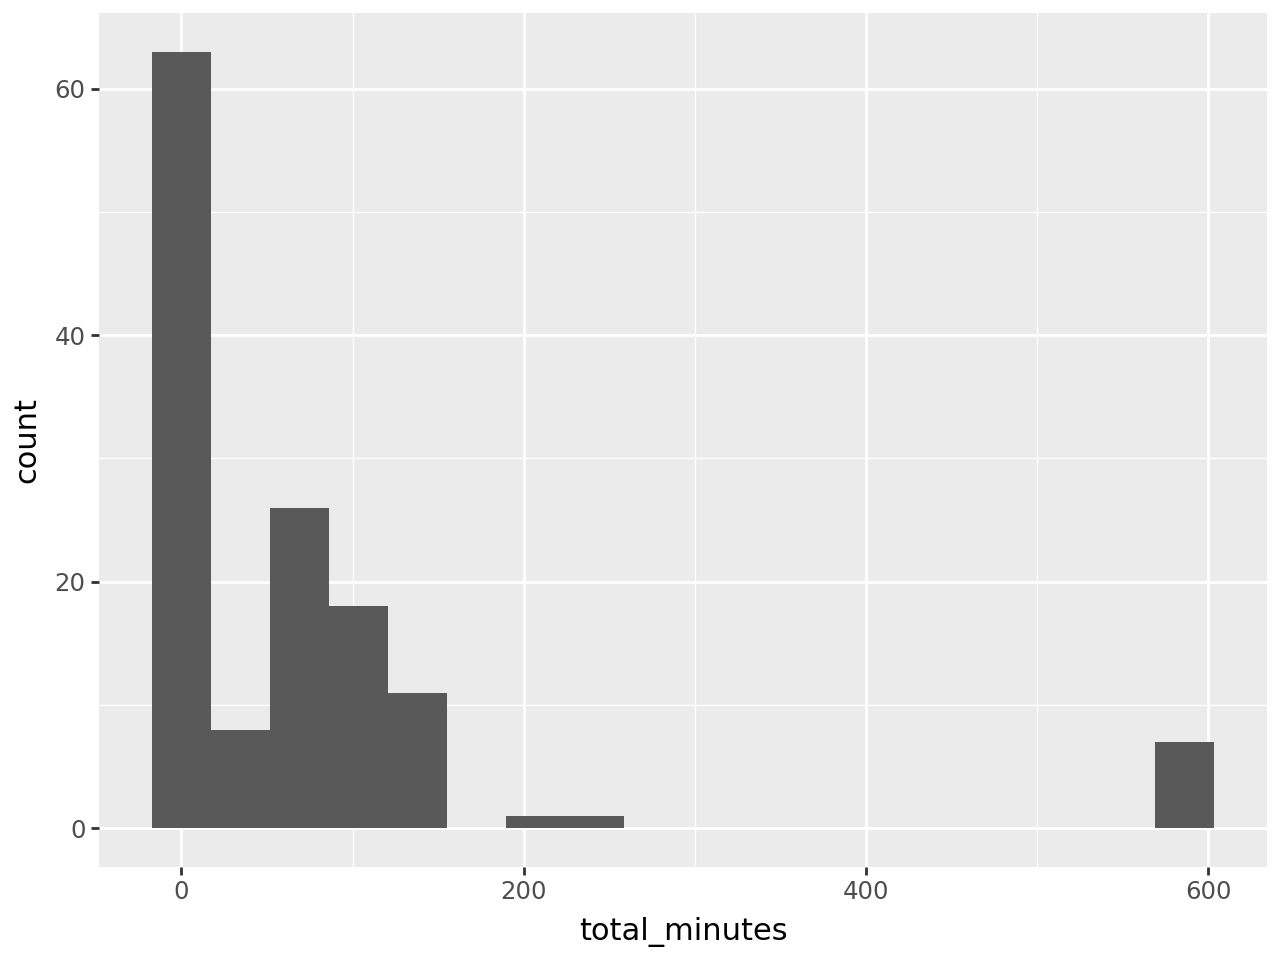

In [54]:
(
    pn.ggplot(
        data=(
            pl.read_csv("3_SARIMAX_trials.csv").with_columns(
                total_minutes=pl.col("time_total_s") / 60
            )
        ),
        mapping=pn.aes("total_minutes"),
    )
    + pn.geom_histogram()
)

In [55]:
best_hyperparams_df = (
    pl.read_csv("3_SARIMAX_trials.csv")
    .sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(
        pl.col("variable").str.replace("config/", ""), pl.col("value").cast(pl.Int64)
    )
)

best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

best_hyperparams

{'p': 12, 'q': 22, 'P': 5, 'Q': 4, 'd': 1, 'D': 1}

In [56]:
model = ARIMA(
    order=(
        best_hyperparams["p"],
        best_hyperparams["d"],
        best_hyperparams["q"],
    ),
    season_length=24,
    seasonal_order=(
        best_hyperparams["P"],
        best_hyperparams["D"],
        best_hyperparams["Q"],
    ),
)

# Fit the model on the full data
model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)

y_preds_val = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

: 

In [ ]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

# Final Model fit

# Model Evaluation

# Archive

## Tuning with skforecast

Order selection:

- p
- d
- q
- P
- D
- Q
- s


p,d,P,Q can be specified using tuples, so as to not include ALL lags up to a certain frequency: 
- Will help with the issue of computational complexity
- How to tune?
    - First set "horizon", then select which lags to turn on. Might set a real long one (like one week) but only activate a few of them
    - Simulated Annealing?

When predicting using last_window and last_window_exog, the internal statsmodels SARIMAX will be updated using its append method. To do this, last_window data must start at the end of the index seen by the forecaster, this is stored in forecaster.extended_index.

In [ ]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

In [ ]:
df_train = df_full["2021-09-01":"2022-08-31"]
df_val = df_full["2022-09-01":"2023-08-31"]

### Manual Test

In [ ]:
forecaster = ForecasterSarimax(
    regressor=Sarimax(
        order=(23, 1, 23),
        seasonal_order=(4, 1, 23, 24),
    )
)

forecaster.fit(
    y=df_train["kWh"].head(10),
    exog=df_train.drop(columns=["kWh"]).head(10),
    suppress_warnings=False,
)

In [ ]:
def validation(model, df_val, verbose=True):
    # Validation loop (predict the next 24 hours)
    val_index = 0
    horizon = 24
    val_preds = []

    while val_index + horizon <= df_val.shape[0]:

        # Check for first day after validation period
        if val_index == 0:
            # Get date from D+1
            df_pred_day = df_val.iloc[val_index : val_index + horizon]

            # Make prediction
            y_pred = model.predict(steps=24, exog=df_pred_day.drop(columns=["kWh"]))

            # Save prediction
            val_preds.append(df_pred_day.filter(["kWh"]).join(y_pred))

            # Set D+0 to what was previously D+1
            df_current_day = df_pred_day

        # All other days after first day
        else:
            # Get date from D+1
            df_pred_day = df_val.iloc[val_index : val_index + horizon]

            # Make prediction
            y_pred = model.predict(
                steps=24,
                exog=df_pred_day.drop(columns=["kWh"]),
                last_window=df_current_day["kWh"],
                last_window_exog=df_current_day.drop(columns=["kWh"]),
            )

            # Save prediction
            val_preds.append(df_pred_day.filter(["kWh"]).join(y_pred))

            # Set D+0 to what was previously D+1
            df_current_day = df_pred_day

        val_index += horizon

        if val_index % (24 * 7) == 0:
            print(f"Hour {val_index} of {df_val.shape[0]}")
            clear_output(wait=True)

    y_preds_val = pd.concat(val_preds)

    return y_preds_val

In [ ]:
y_preds_val = validation(model=forecaster, df_val=df_val)

In [ ]:
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="kWh",
)

### RayTune Tuning Setup

This takes way too long to run

In [ ]:
def sarimax_trainable(config, eval_option="in-sample"):

    try:
        # Fit the model on the training data
        forecaster = ForecasterSarimax(
            regressor=Sarimax(
                order=(config["p"], config["d"], config["q"]),
                seasonal_order=(config["P"], config["D"], config["Q"], 24),
            )
        )

        forecaster.fit(
            y=df_train["kWh"],
            exog=df_train.drop(columns=["kWh"]),
            suppress_warnings=True,
        )

        if eval_option == "in-sample":
            # Get the Information Criterion
            inf_criterion = forecaster.regressor.get_info_criteria("aic")
            train.report({"loss": inf_criterion})
        elif eval_option == "out-of-sample":
            y_preds_val = validation(forecaster)
            loss = root_mean_squared_error(
                y_pred=y_preds_val["pred"], y_true=y_preds_val["kWh"]
            )
            train.report({"loss": loss})

    except Exception as e:
        tune.report(metric=float("inf"))

In [ ]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    tune.with_parameters(
        sarimax_trainable,
        eval_option="out-of-sample",
    ),
    config={
        "p": tune.randint(1, 23),
        "q": tune.randint(1, 23),
        "P": tune.randint(1, 4),
        "Q": tune.randint(1, 4),
        "d": tune.randint(1, 3),
        "D": tune.randint(1, 3),
    },
    metric="loss",
    mode="min",
    name="SARIMAX",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 60 * 10,
    num_samples=-1,
    raise_on_failed_trial=False,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

In [ ]:
analysis.dataframe().to_csv("2_SARIMAX_trials.csv", index=False)

In [ ]:
analysis.best_config